### Goals

* How does the final value of the loss function (without regularization) depend on
    * Prediction from [Candes](http://dx.doi.org/10.1109/TIT.2010.2044061): $nr \log (n)$
        * Problem: this prediction is only for a ***square*** $n \times n$ matrix, with rank $r$?
        * Another problem: This doesn't hold if certain dimensions are much less frequent than others
    * Noise level - change Jensen-Shannon divergence between methylation patterns
        * How to initialize this in a reasonable fasion?
    * $k$ - the number of different methylation patterns (rank of $A$)
    * The relative sizes/proportions of the methylation pattern clusters


* Ways to evaluate fit of $\hat{X}$ to $X$
    * Hard clustering: Hamming distance between $\text{vec}\left[\hat{X}\right]$ and $\text{vec}\left[X\right]$
    * Soft clustering: $\left|\left|\text{vec}\left[\hat{X}\right]  - \text{vec}\left[X\right] \right|\right|_1$
    * Soft clustering: Jensen-Shannon divergence for each row?


* Ways to evaluate fit of $\hat{Y}$ to $P$ (probabilities of methylation)
    * First, derive $\hat{P}$ from $\hat{Y}$
        * Logistic loss: $\hat{Y}_{ij} = \text{logit}[\hat{P}_{ij}] \Rightarrow \hat{P}_{ij} = \text{lgc}[\hat{Y}_{ij}]$
    * Then calculate Jensen-Shannon divergence between each row, $\hat{p_j}$ and $p_j$ with $m_{ij} = (\hat{p}_{ij} + p_{ij})/2$
        * $D_{JS}(\hat{p}_j || p_j) = \sum_i \left\{ \frac{1}{2} \left[ \hat{p}_{ij} \log_2 \frac{\hat{p}_{ij}}{m_{ij}} + (1-\hat{p}_{ij}) \log_2 \frac{1-\hat{p}_{ij}}{1-m_{ij}} \right] + \frac{1}{2} \left[ p_{ij} \log_2 \frac{p_{ij}}{m_{ij}} + (1-p_{ij}) \log_2 \frac{1-p_{ij}}{1-m_{ij}} \right] \right\}$
    * We would expect the divergence (noise in the fit) to be higher for smaller clusters
    

* Could also calculate data liklihood as a measure of interest


* Try kmeans++ initialization


* Try initializing logistic loss model with results from quadratic loss
    * This doesn't seem to work for some reason


In [27]:
using LowRankModels
using Distributions
import Distances: Hamming
include("methylation_functions.jl");
include("glrm_wrappers.jl")

find_observations (generic function with 1 method)

In [28]:
function fit_model_1(A,P;n_repeats=20)
    # Fit initial soft-clustering model
    # (quadratic loss, nonegative and L1 norm regularization on X)
    X1,Y1,ch1 = run_batch(A,size(P,1),quadratic(),nonneg_onereg(),zeroreg(),nothing,nothing,n_repeats);
    
    # Fit secondary hard-clustering model, use soft-clustering as initialization
    # (logistic loss, rows of X one-sparse with unit length)
    X2,Y2,ch2 = run_batch(A,size(P,1),quadratic(),unitonesparse(),zeroreg(),X1,Y1,n_repeats);
    
    X,Y = sort_solution(X2,Y2)
    
    # Derive estimated methylation probabilities from Y
    #Y = 1 ./ (1 + exp(-Y))
    Y = (Y - minimum(Y) + 0.0005)./(maximum(Y) - minimum(Y)+0.001)
    
    return X,Y,ch2
end

function sort_solution(X,Y)
    # re-sort rows/columns of X and Y so that the largest cluster is first
    c_order = sortperm(squeeze(sum(X,1),1),rev=true)
    X = X[:,c_order]
    Y = Y[c_order,:]
    return X,Y
end

function evaluate_model_2clusters(X,Y,A,P,c)
    # Compare fitted X to true X
    X_real = zeros(size(X))
    for i = 1:size(X,1)
        X_real[i,c[i]] = 1
    end
    Xdist = Distances.evaluate(Hamming(),vec(X),vec(X_real))
    
    # Compare P_est to true methylation probabilities, P
    Ydist = zeros(size(Y,1))
    for j = 1:size(Y,1)
        Ydist[j] = d_js_multivar_bern(vec(Y[j,:]),vec(P[j,:])) # imported from methylation_functions.jl
    end
    
    return Xdist,Ydist,X_real
end

evaluate_model_2clusters (generic function with 1 method)

In [29]:
n_reads=100
read_length=30
P_dist = [1:3:15]
n_dist = length(P_dist)
n_replicates = 3
k = 2

Xest = zeros(n_reads,k,n_dist,n_replicates)
Yest = zeros(k,n_reads,n_dist,n_replicates)
Xreal = zeros(n_reads,k,n_dist,n_replicates)
Yreal = zeros(k,n_reads,n_dist,n_replicates)
Xdist = zeros(length(P_dist),n_replicates)
Ydist = zeros(length(P_dist),n_replicates,2)

for a = 1:length(P_dist)
    println("--- a=",a," ---")
    for b=1:n_replicates    
        A,P,c = generate_reads(N=n_reads,W=read_length,targ_dist=P_dist[a])
        X,Y,ch = fit_model_1(A,P)
        Xdist[a,b],Ydist[a,b,:],Xreal[:,:,a,b] = evaluate_model_2clusters(X,Y,A,P,c);
        Xest[:,:,a,b] = X
        Yest[:,:,a,b] = Y
        Yreal[:,:,a,b] = P
    end
end

--- a=1 ---
didnt converge, trying again
Best Objective: 1937.5688676659977
Best Objective: 2002.152741415662
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
Best Objective: 1928.8481701468513
Best Objective: 1995.9150721877697
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
Best Objective: 1832.5069185960976
Best Objective: 1890.461145775599
--- a=2 ---
didnt converge, trying again
didnt converge, trying again
Best Objective: 2002.8061762612854
Best Objective: 2068.544174748138
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
didnt converge, trying again
did

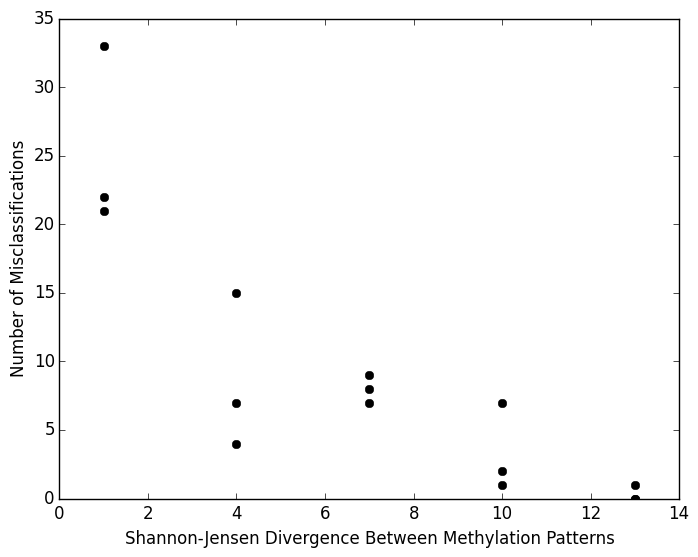

PyObject <matplotlib.text.Text object at 0x7f282b8a1250>

In [24]:
figure()
for a = 1:length(P_dist)
    plot(P_dist[a]*ones(n_replicates),vec(Xdist[a,:])./2,"ok")
end
xlabel("Shannon-Jensen Divergence Between Methylation Patterns")
ylabel("Number of Misclassifications")

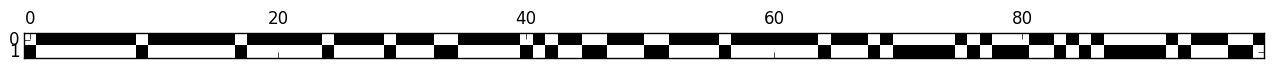

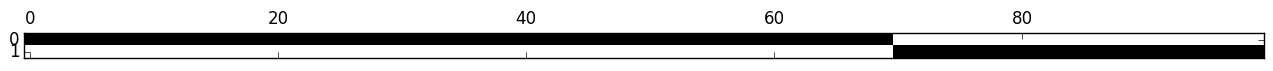

PyObject <matplotlib.image.AxesImage object at 0x7f2829c3c910>

In [59]:
matshow(Xest[:,:,1,1]',cmap=ColorMap("Greys"))
matshow(Xreal[:,:,1,1]',cmap=ColorMap("Greys"))

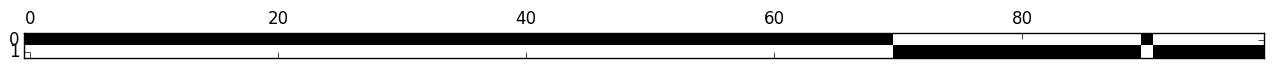

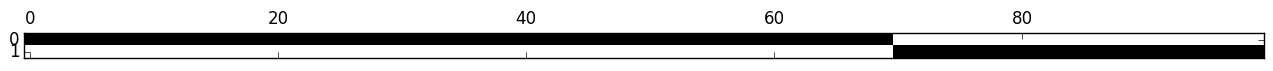

PyObject <matplotlib.image.AxesImage object at 0x7f28294ea950>

In [60]:
matshow(Xest[:,:,end,1]',cmap=ColorMap("Greys"))
matshow(Xreal[:,:,end,1]',cmap=ColorMap("Greys"))

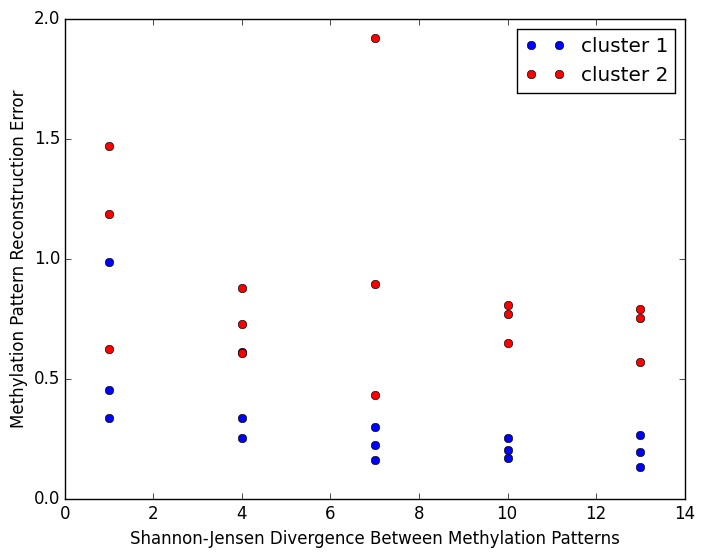

PyObject <matplotlib.legend.Legend object at 0x7f282b4b7d50>

In [37]:
figure()
for a = 1:length(P_dist)
    plot(P_dist[a]*ones(n_replicates),vec(Ydist[a,:,1])./2,"ob")
    plot(P_dist[a]*ones(n_replicates),vec(Ydist[a,:,2])./2,"or")
end
xlabel("Shannon-Jensen Divergence Between Methylation Patterns")
ylabel("Methylation Pattern Reconstruction Error")
legend(("cluster 1", "cluster 2"))

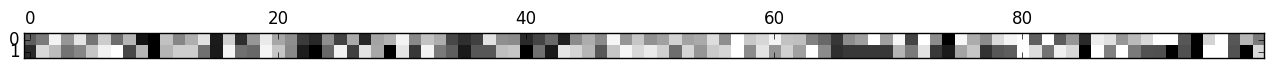

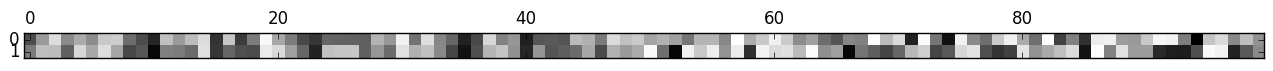

PyObject <matplotlib.image.AxesImage object at 0x7f282c2d91d0>

In [40]:
matshow(Yest[:,:,1,1],cmap=ColorMap("Greys"))
matshow(Yreal[:,:,1,1],cmap=ColorMap("Greys"))

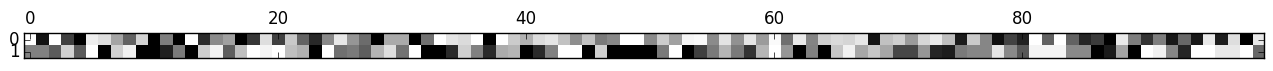

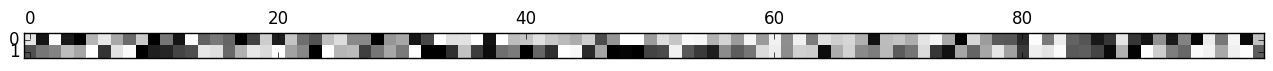

PyObject <matplotlib.image.AxesImage object at 0x7f282c381750>

In [41]:
matshow(Yest[:,:,end,1],cmap=ColorMap("Greys"))
matshow(Yreal[:,:,end,1],cmap=ColorMap("Greys"))

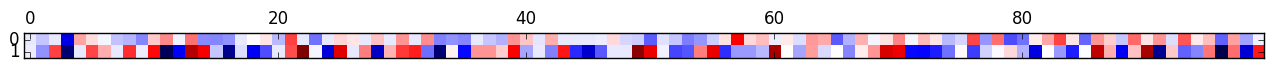

PyObject <matplotlib.image.AxesImage object at 0x7f282c236fd0>

In [48]:
matshow(Yest[:,:,end,2]-Yreal[:,:,end,2],cmap=ColorMap("seismic"))

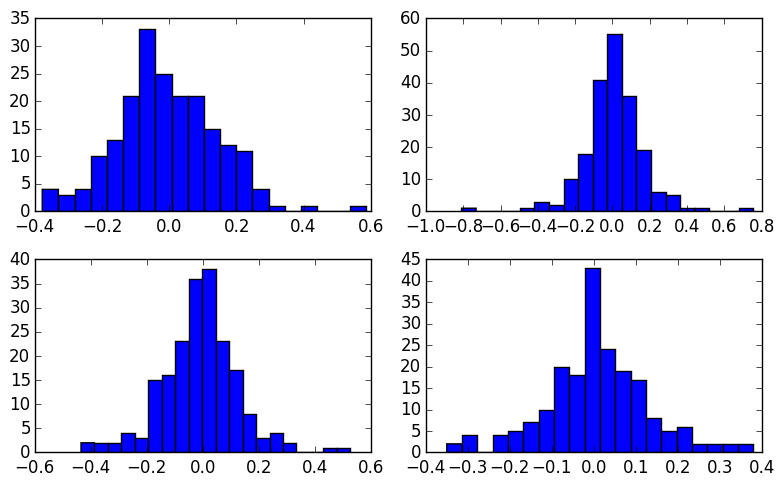

In [56]:
figure(figsize=(8,5))
subplot(2,2,1)
PyPlot.plt.hist(vec(Yest[:,:,1,2]-Yreal[:,:,1,2]),20);
subplot(2,2,2)
PyPlot.plt.hist(vec(Yest[:,:,2,2]-Yreal[:,:,2,2]),20);
subplot(2,2,3)
PyPlot.plt.hist(vec(Yest[:,:,3,2]-Yreal[:,:,3,2]),20);
subplot(2,2,4)
PyPlot.plt.hist(vec(Yest[:,:,end,2]-Yreal[:,:,end,2]),20);
tight_layout()